# How to use the ParlaSent model? A step-by-step tutorial (/w stanza)

Authors: Mochtak, Michal, Peter Rupnik, Taja Kuzman, and Nikola Ljubešić

Date: 1 june 2025

## Introductory remarks ⛳

This is an interactive Jupyter notebook that presents a step-by-step tutorial on how to use the ParlaSent model with your own data. The overall structure of the notebook is organized around two elements: 1) sentence extraction and 2) sentence annotation.

If you use this tutorial, please cite the paper:


> Mochtak, Michal, Peter Rupnik, and Nikola Ljubešić. 2024. “The ParlaSent Multilingual Training Dataset for Sentiment Identification in Parliamentary Proceedings.” In Proceedings of the 2024 Joint International Conference on Computational Linguistics, Language Resources and Evaluation (LREC-COLING 2024), edited by Nicoletta Calzolari, Min-Yen Kan, Veronique Hoste, Alessandro Lenci, Sakriani Sakti, and Nianwen Xue, 16024–36. Torino, Italia: ELRA and ICCL. https://aclanthology.org/2024.lrec-main.1393.

**NOTE: As of June 1, 2025, the original tutorial using the trankit library no longer works due to broken dependencies that cannot be resolved within the same Colab session. As a workaround, the trankit library has been replaced with the stanza toolkit (how_to_use_authdetect_w_stanza.ipynb). Stanza performs the same functions as trankit and does not have the same dependency compatibility issues. This is the recommended pipeline for Google Colab and serves as a functional alternative to trankit, if needed.**


## Prerequisities ⚡
Google Colab is an interactive development environment with access to computational resources that are easy to utilize free of charge (read more about it here: https://colab.research.google.com/).

To use the ParlaSent model, you first need to connect to an interactive session with access to a graphical processing unit. To do this, click "Runtime" in the top toolbar and select "Change runtime type":
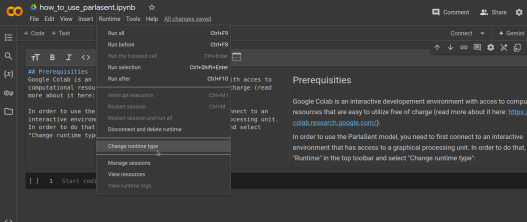
<br>
<br>
After a pop-up appears, select any available GPU accelerator and save your selection:

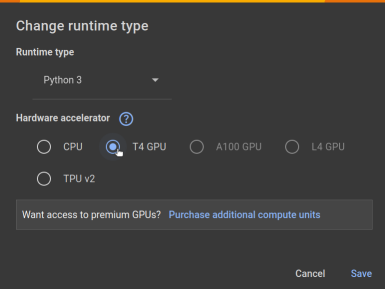

Finally, in the top right corner, click "Connect." After a moment, a green check mark (✔) will appear, indicating that your virtual session has been successfully set up:

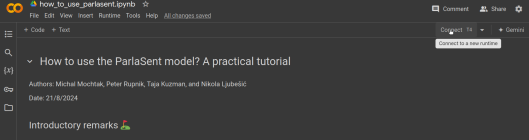

## Loading data for processing 💾
This notebook is designed for a simple use case that expects users to prepare their data outside the Google Colab environment as a plain .csv file and then upload it for further processing. The repository for this paper contains a sample file that you can use as a guide for formatting your own data. The file contains 124 speeches in English from the debate on the proposal for a regulation of the European Parliament and of the Council setting emission performance standards for new passenger cars and new light commercial vehicles held on 3rd March 2018. The file has just two columns: "doc_id" as a document identifier and "speech" for the actual transcripts (the pipeline does not require anything else).

To use the file (or any other file you prepare), upload it to your interactive session by clicking the folder icon on the left and dragging and dropping your file into the area under the "sample_data" folder. The file will be uploaded to your interactive session and will be available for processing. It is important to note that the file exists only in this interactive session and will be deleted when you close it. This applies to any file you create in your session (e.g., the processed data).

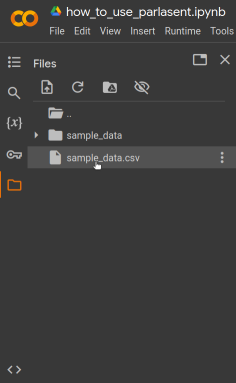



## Processing the data 🎆

The processing pipeline can be divided into two steps: 1) sentence extraction and 2) sentence annotation. From this point on, the notebook will also include code cells that can be executed by clicking the small "play" icon next to them (hover over the cell to make it visible). The only cell you may need to modify is the one below, which contains a few meta-parameters that will be used in the pipeline.

### Loading the necessary packages 💻
To process the input data, we need to install and load a few packages we will use.

In [1]:
# Before we start, we will set a few meta-parameters for the pipeline to use.
language = "english"  # This parameter specifies the language of your input text so Trankit can load the appropriate sentence parser. In this example, the speeches are in English; check the available languages at https://trankit.readthedocs.io/en/latest/pkgnames.html (look for the Code Name for pipeline initialization).
text_column = "speech"  # Name of the column in the .csv file containing the input text to be analyzed. In this example, the column we will process is "speech".
doc_id = "doc_id"  # Name of the column with the unique identifier for each text to be processed. In this example, the column is "doc_id".
filename = "sample_data.csv"  # Name of the file you uploaded to Google Colab that you want to process. The tutorial folder contain a dummy dataset you need to upload here.

In [ ]:
# Install missing/needed libraries to your session; this needs to be done each time you
# open the notebook, as the session is interactive. It takes a while.
!pip install simpletransformers
!pip install stanza

In [3]:
# Load the necessary libraries.
import simpletransformers.classification as cl
import stanza
import pandas as pd

### Step 1: Sentence extraction ⛏
Now that all the necessary packages are loaded and ready to use, we can proceed with the first step—sentence extraction.

In [4]:
# Load the dataset you want to process. This tutorial uses a plain .csv file for simplicity.
df = pd.read_csv(filename)

In [ ]:
# Load the stanza pipeline with the language model you specified earlier.
p = stanza.Pipeline(language, processors='tokenize')

In [ ]:
# Check the dataset to be sure it was read in correctly.
df

In [9]:
# Split texts into sentences. We use a simple loop as the model processes inputs sequentially.
sentences = []
for n in range(0, len(df["text"])):
  doc = p(df["text"][n])
  one_text = [sentence.text for sentence in doc.sentences]
  one_text_df = pd.DataFrame({
    'doc_id': n+1,
    'id': range(1, len(one_text) + 1),
    'text': one_text})
  sentences.append((one_text_df))

# Concatenate the list and reset the index.
sentences_final = pd.concat(sentences)
sentences_final.reset_index(drop=True, inplace=True)

In [ ]:
# Check the result of sentence extraction. It is a data frame with the following columns:
# - doc_id: Refers to the original document.
# - id: Refers to the sentence ID within the processed input (e.g., speech).
# - text: Contains the extracted grammatical units (i.e., the sentences).

sentences_final

### Step 2: Sentiment annotation 🌡
With the extracted sentences, we can proceed to the second step: sentiment annotation.

In [ ]:
# Load the ParlaSent model from the Huggingface Hub.
model = cl.ClassificationModel("xlmroberta", "classla/xlm-r-parlasent")

In [ ]:
# Annotate the prepared sentences with the ParlaSent model.
prediction = model.predict(to_predict = sentences_final["text"].tolist())

final_df = sentences_final.assign(predict = prediction[1])

In [ ]:
# Check the result. The `final_df` data frame now contains an additional column
# called "predict" with the predictions made by the model. Since the classification model
# predicts the label (score) on a continuous scale, similar to a regression model,
# it can produce scores above or below the scale used for training (0-5).
# It is worth mentioning that annotating 124 speeches containing 1,289 sentences
# took approximately 6 seconds (on a T4 GPU).
final_df

In [18]:
# Save the annotated data as a .csv file. The new file will be located in the same
# directory as the input file you uploaded at the beginning. If it does not
# appear automatically, click the refresh button (the circled arrow) to reload
# the folder contents. To download the file, right-click on it and select "Download"
# to save it to your local machine.
final_df.to_csv('output.csv', index=False)

## Closing remarks 👋
The tutorial has guided you through the entire annotation pipeline. We demonstrated how easy it is to set up and execute the process on your own data. By defining just a few meta-parameters related to your uploaded document (such as column names and the language you want to analyze), you can quickly annotate your own text data. Whether the text is in English, German, Czech, Polish, or Italian, the model will handle it effectively. The result is a straightforward data frame with annotated sentences that can be further processed or aggregated for specific research purposes (e.g., speech levels, time periods, or groups) and merged with the available metadata using the `doc_id` identifier.
